In [1]:
import os
import sys
import subprocess
import zipfile
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

🔍 Scanning and splitting files...
⚖️ Balancing Dataset: Max class count is 776. Oversampling others...
✅ Balanced Train Size: 10864 (was 3618)
📊 Test Size: 931
🚀 Loading google/vit-base-patch16-224...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([14]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([14, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔥 Starting Optimized Training (15 Epochs, Balanced Data)...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,2.148000,2.199193,0.266380,0.181054
2,1.314300,1.781684,0.479055,0.345784
3,0.883000,1.718389,0.498389,0.330790
4,0.746100,1.768762,0.491944,0.309180
5,0.669300,1.747828,0.516649,0.314604
6,0.619700,1.774292,0.526316,0.319681
7,0.597700,1.780606,0.531686,0.322211
8,0.577600,1.809401,0.533835,0.297382
9,0.571800,1.819501,0.528464,0.316213
10,0.565200,1.817458,0.526316,0.320186



📊 Final Evaluation...


🏆 Final Accuracy: 0.4791
⭐ Final F1 Score (Macro): 0.3458

                       precision    recall  f1-score   support

    Happily Surprised       0.68      0.65      0.66       156
    Happily Disgusted       0.34      0.57      0.43        54
        Sadly Fearful       0.22      0.35      0.27        26
          Sadly Angry       0.50      0.26      0.34        50
      Sadly Surprised       0.21      0.38      0.27        24
      Sadly Disgusted       0.53      0.56      0.55       162
      Fearfully Angry       0.44      0.44      0.44        32
  Fearfully Surprised       0.70      0.43      0.53       138
  Fearfully Disgusted       0.00      0.00      0.00         6
    Angrily Surprised       0.25      0.36      0.29        42
    Angrily Disgusted       0.53      0.48      0.51       201
Disgustedly Surprised       0.15      0.16      0.15        32
      Happily Fearful       0.20      0.25      0.22         4
        Happily Angry       0.14      0.25      0.18      

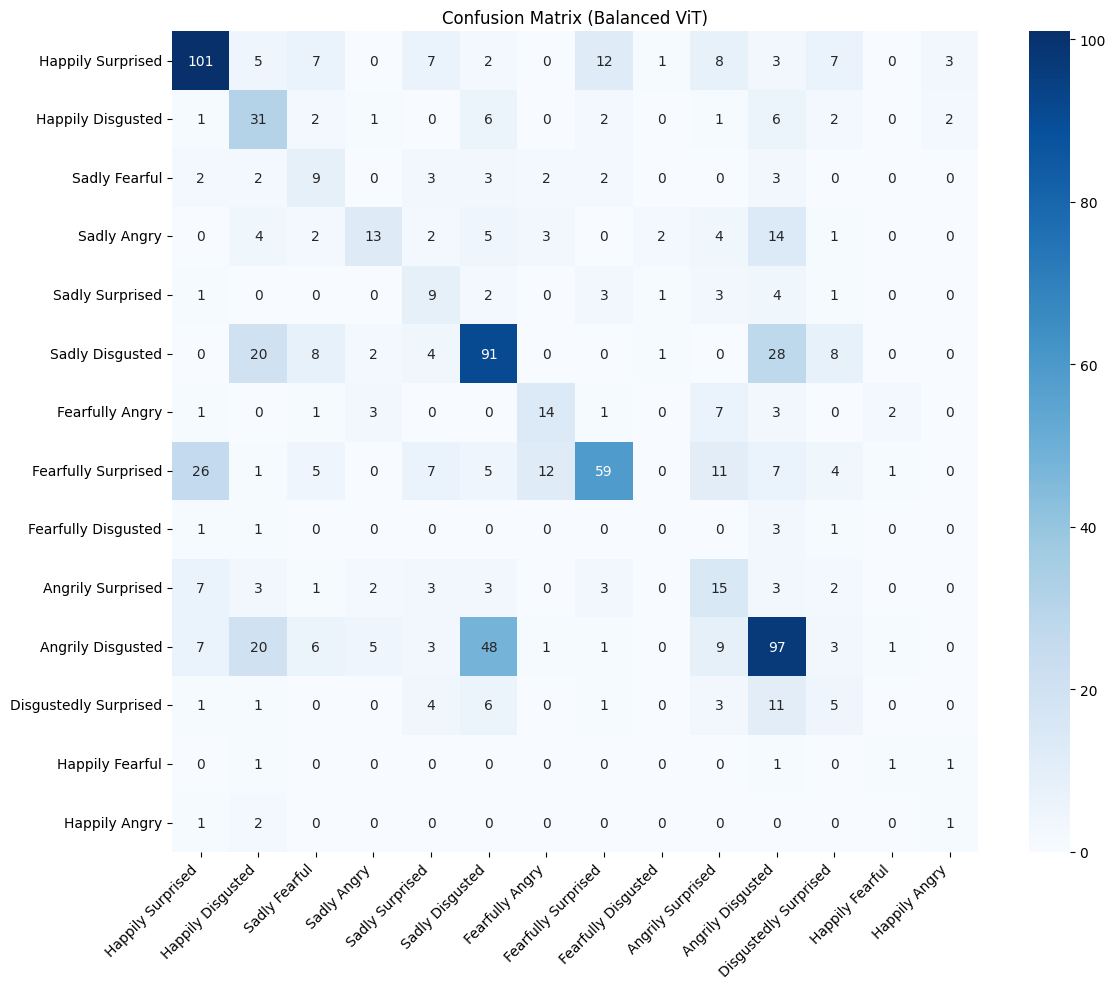

In [12]:
import os
import sys
import subprocess
import zipfile
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from PIL import Image
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import random

# =============================================================================
# 1. AUTO-INSTALL LIBRARIES (Fast & Clean)
# =============================================================================
def install_libs():
    libs = ["transformers", "accelerate", "datasets", "scikit-learn", "torchvision"]
    try:
        import transformers
        import torchvision
    except ImportError:
        print("⚡ Installing optimized libraries for ViT...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + libs)
        print("✅ Libraries installed.")

install_libs()

from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
from torchvision import transforms

# =============================================================================
# 2. DATA ENGINE (Oversampling & Balancing)
# =============================================================================

EMOTION_MAP = {
    0: "Happily Surprised", 1: "Happily Disgusted", 2: "Sadly Fearful",
    3: "Sadly Angry", 4: "Sadly Surprised", 5: "Sadly Disgusted",
    6: "Fearfully Angry", 7: "Fearfully Surprised", 8: "Fearfully Disgusted",
    9: "Angrily Surprised", 10: "Angrily Disgusted", 11: "Disgustedly Surprised",
    12: "Happily Fearful", 13: "Happily Angry", 14: "Sadly Happy"
}

class RAFCE_Engine:
    def __init__(self, image_dir="aligned"):
        self.image_dir = image_dir
        if not os.path.exists(image_dir) and os.path.exists("aligned.zip"):
            print("📂 Unzipping dataset...")
            with zipfile.ZipFile("aligned.zip", 'r') as z:
                z.extractall(".")
            print("✅ Unzipped.")
        self.available_files = set(os.listdir(image_dir)) if os.path.exists(image_dir) else set()

    def get_real_path(self, filename):
        if filename in self.available_files: return os.path.join(self.image_dir, filename)
        aligned = filename.replace(".jpg", "_aligned.jpg")
        if aligned in self.available_files: return os.path.join(self.image_dir, aligned)
        return None

    def load_data(self):
        if not os.path.exists("RAFCE_emolabel.txt"):
            print("🔴 Error: RAFCE_emolabel.txt missing.")
            return [], [], []

        labels_map = {}
        with open("RAFCE_emolabel.txt", "r") as f:
            for line in f:
                p = line.strip().split()
                if len(p) >= 2: labels_map[p[0]] = int(p[1])

        partitions = {}
        if os.path.exists("RAFCE_partition.txt"):
            with open("RAFCE_partition.txt", "r") as f:
                for line in f:
                    p = line.strip().split()
                    if len(p) >= 2: partitions[p[0]] = int(p[1])

        train_data_raw, test_data = [], []
        found_labels = []

        print("🔍 Scanning and splitting files...")
        for fname, label in labels_map.items():
            path = self.get_real_path(fname)
            if not path: continue

            is_train = True
            if partitions:
                part = partitions.get(fname, 1)
                if str(part).lower() in ["2", "test"]: is_train = False

            item = {"path": path, "label": label}
            found_labels.append(label)

            if is_train: train_data_raw.append(item)
            else: test_data.append(item)

        unique_labels = sorted(list(set(found_labels)))

        # --- AGGRESSIVE OVERSAMPLING ---
        # 1. Count frequencies
        label_counts = Counter([x['label'] for x in train_data_raw])
        max_count = max(label_counts.values())
        print(f"⚖️ Balancing Dataset: Max class count is {max_count}. Oversampling others...")

        train_data_balanced = []
        # 2. Group by label
        data_by_label = defaultdict(list)
        for item in train_data_raw:
            data_by_label[item['label']].append(item)

        # 3. Flatten and Duplicate
        for label in unique_labels:
            items = data_by_label[label]
            count = len(items)
            if count == 0: continue

            # Add originals
            train_data_balanced.extend(items)

            # Calculate how many to add
            needed = max_count - count
            if needed > 0:
                # Randomly sample 'needed' items from existing ones
                extras = random.choices(items, k=needed)
                train_data_balanced.extend(extras)

        # Shuffle to mix classes
        random.shuffle(train_data_balanced)

        print(f"✅ Balanced Train Size: {len(train_data_balanced)} (was {len(train_data_raw)})")
        print(f"📊 Test Size: {len(test_data)}")

        return train_data_balanced, test_data, unique_labels

# =============================================================================
# 3. DATASET WITH AUGMENTATION
# =============================================================================

class ViTDataset(Dataset):
    def __init__(self, data_list, processor, augment=False):
        self.data = data_list
        self.processor = processor
        self.augment = augment

        # Aggressive Augmentation for Training
        # Since we duplicated data, we MUST distort it so the model learns features, not pixels.
        self.aug_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        try:
            image = Image.open(item['path']).convert("RGB")

            # Apply Augmentation BEFORE Processor
            if self.augment:
                image = self.aug_transforms(image)

            inputs = self.processor(images=image, return_tensors="pt")
            return {
                "pixel_values": inputs["pixel_values"].squeeze(0),
                "labels": torch.tensor(item['label'], dtype=torch.long)
            }
        except Exception:
            return self.__getitem__((idx + 1) % len(self))

# =============================================================================
# 4. METRICS & TRAINING
# =============================================================================

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    return {"accuracy": acc, "f1_macro": f1}

def run_training():
    engine = RAFCE_Engine()
    # LOAD BALANCED DATA
    train_data, test_data, unique_labels = engine.load_data()

    if not train_data:
        print("❌ No data found.")
        return

    # No need for class weights in loss anymore because data is physically balanced!
    # This is often more stable for Transformers.

    model_name = "google/vit-base-patch16-224"
    print(f"🚀 Loading {model_name}...")

    processor = ViTImageProcessor.from_pretrained(model_name)
    model = ViTForImageClassification.from_pretrained(
        model_name,
        num_labels=max(unique_labels) + 1, # Ensure output layer fits max ID
        ignore_mismatched_sizes=True
    )

    # Enable Augmentation only for Train
    train_dataset = ViTDataset(train_data, processor, augment=True)
    test_dataset = ViTDataset(test_data, processor, augment=False)

    training_args = TrainingArguments(
        output_dir="./vit_rafce_results_optimized",
        num_train_epochs=15,             # Increased from 5 -> 15
        per_device_train_batch_size=32,  # T4 can handle 32 for ViT-Base
        per_device_eval_batch_size=32,
        learning_rate=3e-5,              # Slightly higher initial LR
        weight_decay=0.01,
        warmup_ratio=0.1,                # Warmup prevents early overfitting
        eval_strategy="epoch",
        save_strategy="epoch",
        label_smoothing_factor=0.1,      # Helps with ambiguous expressions
        logging_dir='./logs',
        logging_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        fp16=True,
        save_total_limit=1,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )

    print("🔥 Starting Optimized Training (15 Epochs, Balanced Data)...")
    trainer.train()

    print("\n📊 Final Evaluation...")
    metrics = trainer.evaluate()
    print(f"🏆 Final Accuracy: {metrics['eval_accuracy']:.4f}")
    print(f"⭐ Final F1 Score (Macro): {metrics['eval_f1_macro']:.4f}")

    # Detailed Report
    preds_output = trainer.predict(test_dataset)
    y_preds = np.argmax(preds_output.predictions, axis=1)
    y_true = preds_output.label_ids

    target_names = [EMOTION_MAP.get(i, f"Class {i}") for i in unique_labels]

    print("\n" + classification_report(y_true, y_preds, target_names=target_names, zero_division=0))

    cm = confusion_matrix(y_true, y_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix (Balanced ViT)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("vit_confusion_matrix_optimized.png")
    print("✅ Results saved.")

    trainer.save_model("best_vit_rafce_model_opt")
    processor.save_pretrained("best_vit_rafce_model_opt")

if __name__ == "__main__":
    run_training()